In [1]:
import os
import numpy as np
import sys
print(sys.executable)
import tensorflow as tf
from tensorflow.keras import layers, models
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score



2025-04-10 13:54:53.411394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/home/nwertheim/Master-Thesis/thesisenv/bin/python


2025-04-10 13:54:53.426343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744286093.440392 2339051 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744286093.444686 2339051 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744286093.456632 2339051 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744286093.456650 2339051 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744286093.456652 2339051 computation_placer.cc:177] computation placer alr

In [2]:
save_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA.npy")
target_data = np.load(save_dir, allow_pickle=True)
print(len(target_data))
print(target_data[0])
num_none_preterm = sum(1 for item in target_data if item['preterm'] is None)
print(f"Number of instances with None in 'preterm': {num_none_preterm}")
target_data = [item for item in target_data if item['preterm'] is not None]
print(f"Remaining instances after deletion: {len(target_data)}")
import matplotlib.pyplot as plt
from collections import Counter



1002
{'record_name': 'Hopper-2023_05_25_12_03_38-0000010090-0003-chan0', 'signal': array([[-1.70320951],
       [-3.4187519 ],
       [-2.48399421],
       ...,
       [ 0.73116871],
       [ 0.4095313 ],
       [ 0.95039407]]), 'fs': 20, 'preterm': 0}
Number of instances with None in 'preterm': 144
Remaining instances after deletion: 858


Total windows created: 10578
[-1.70320951 -3.4187519  -2.48399421 ...  0.24288739  0.24469773
  0.24461031]
              precision    recall  f1-score   support

           0       0.92      0.27      0.41       674
           1       0.80      0.99      0.88      1971

    accuracy                           0.81      2645
   macro avg       0.86      0.63      0.65      2645
weighted avg       0.83      0.81      0.76      2645



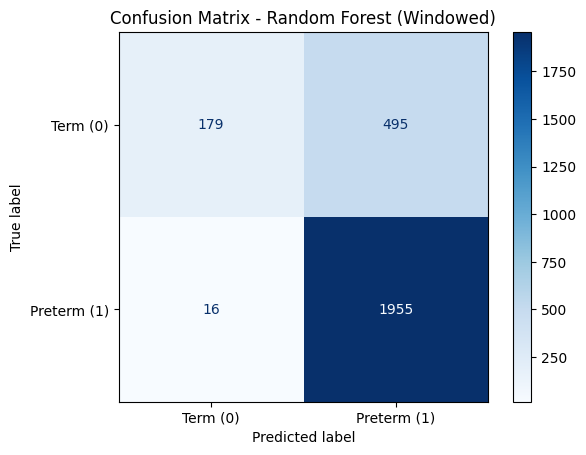

In [3]:
# Creating Windows of 10 Minutes

def create_windows(data, window_size):
    """
    Splits each signal in the dataset into non-overlapping windows.

    Parameters:
    - data: list of dicts with keys 'signal', 'preterm', and 'record_name'
    - window_size: int, number of time steps per window (e.g., 12000 for 10 minutes at 20Hz)

    Returns:
    - List of dictionaries with 'signal', 'label', and 'record_name'
    """
    windowed_data = []

    for item in data:
        signal = item['signal']
        label = item['preterm']
        record_name = item['record_name']
        
        num_windows = len(signal) // window_size
        
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = signal[start:end]
            windowed_data.append({
                'signal': window,
                'label': label,
                'record_name': record_name
            })

    return windowed_data

# Step 1: Create windows
WINDOW_SIZE = 12000  # 10 minutes at 20Hz
windowed_data = create_windows(target_data, WINDOW_SIZE)
print(f"Total windows created: {len(windowed_data)}")

# Step 2: Prepare X and y
X = [d['signal'] for d in windowed_data]
y = [d['label'] for d in windowed_data]
X = [x.flatten() for x in X] # otherwise 3D-array
print(X[0])

X = np.stack(X)
y = np.array(y)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Step 4: Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict
y_pred = clf.predict(X_test)

# Step 6: Evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term (0)", "Preterm (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (Windowed)")
plt.show()

AUC: 0.9223
Average Precision (AP): 0.9507
              precision    recall  f1-score   support

           0       0.91      0.51      0.65        81
           1       0.76      0.97      0.86       134

    accuracy                           0.80       215
   macro avg       0.84      0.74      0.75       215
weighted avg       0.82      0.80      0.78       215



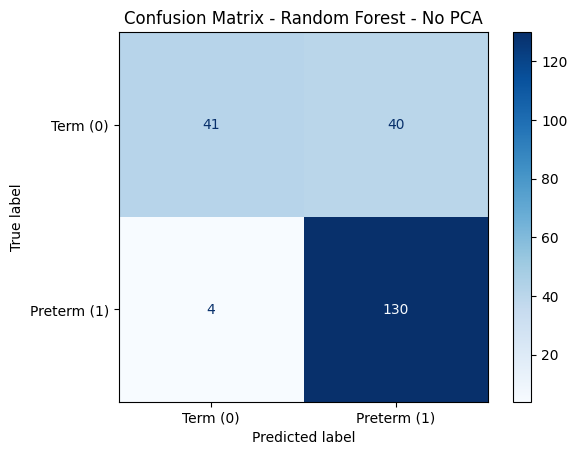

In [4]:

# Prepare data
X = [d['signal'][:12000] for d in target_data if len(d['signal']) >= 12000]  # truncate/pad to fixed length
y = [d['preterm'] for d in target_data if len(d['signal']) >= 12000]
X = [x.flatten() for x in X] # otherwise 3D-array

X = np.stack(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get the probability for class 1 (Preterm)

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Average Precision (AP)
ap = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision (AP): {ap:.4f}")

# Step 6: Evaluation (as before)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term (0)", "Preterm (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest - No PCA")
plt.show()

167
{'record_name': np.str_('Hopper-2023_05_25_12_03_38-0000010090-0003'), 'signal': array([[-0.70613831],
       [-0.9054771 ],
       [-0.7669727 ],
       ...,
       [-0.4010203 ],
       [-0.44152144],
       [-0.37364218]]), 'fs': 20, 'preterm': 0}
Number of instances with None in 'preterm': 24
Remaining instances after deletion: 143
              precision    recall  f1-score   support

           0       0.40      0.14      0.21        14
           1       0.61      0.86      0.72        22

    accuracy                           0.58        36
   macro avg       0.51      0.50      0.46        36
weighted avg       0.53      0.58      0.52        36



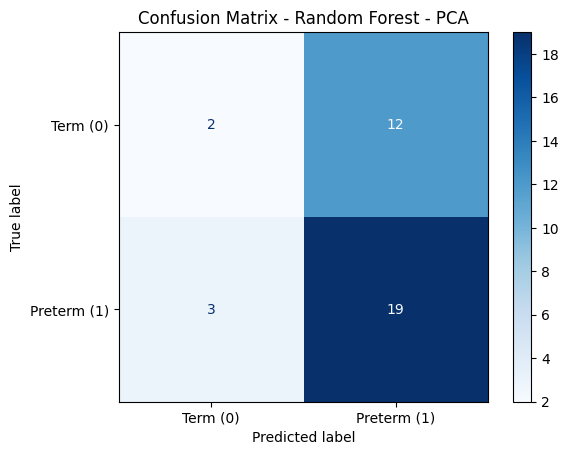

In [5]:
save_dir = os.path.join(univariate_data_path, "target_univariate.npy")
target_data = np.load(save_dir, allow_pickle=True)
print(len(target_data))
print(target_data[0])
num_none_preterm = sum(1 for item in target_data if item['preterm'] is None)
print(f"Number of instances with None in 'preterm': {num_none_preterm}")
target_data = [item for item in target_data if item['preterm'] is not None]
print(f"Remaining instances after deletion: {len(target_data)}")
import matplotlib.pyplot as plt
from collections import Counter

# Prepare data
X = [d['signal'][:12000] for d in target_data if len(d['signal']) >= 12000]  # truncate/pad to fixed length
y = [d['preterm'] for d in target_data if len(d['signal']) >= 12000]
X = [x.flatten() for x in X] # otherwise 3D-array

X = np.stack(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term (0)", "Preterm (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest - PCA")
plt.show()

